In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [24]:
WINDOW_LENGTH = 256  # data window
STRIDE = 128        # stride
BATCH_SIZE = 64  # batch
EPOCHS = 20  # epoch
LEARNING_RATE = 0.001  # lr
PROJ_DIM = 128  # embedding dimension

In [25]:
datapath = "../../../data/SisFall_dataset/" 

In [26]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [27]:
adl_activities = [f'D{str(i).zfill(2)}' for i in range(1, 20)]  # D01-D19
fall_activities = [f'F{str(i).zfill(2)}' for i in range(1, 16)]  # F01-F15

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

adult_subjects = [f'SA{str(i).zfill(2)}' for i in range(1, 24)]  # SA01-SA23
elderly_subjects = [f'SE{str(i).zfill(2)}' for i in range(1, 16)]  # SE01-SE15

train_sa = adult_subjects[:16]    # 16 subjects
val_sa = adult_subjects[16:19]    # 3 subjects
test_sa = adult_subjects[19:]     # 4 subjects

train_se = elderly_subjects[:10]  # 10 subjects
val_se = elderly_subjects[10:12]  # 2 subjects
test_se = elderly_subjects[12:]   # 3 subjects

train_split = train_sa + train_se
val_split = val_sa + val_se
test_split = test_sa + test_se

In [28]:
def read_sensor_file(filepath) :
   """
       first 6 columns : ADXL345 acc + ITG3200 gyro
   """
   with open(filepath, 'r') as file:
       content = file.read()

   content = content.replace(' ', '')  # delete blank
   rows = []

   for line in content.split(';\n'): 
       if line.strip():
           try:
               values = [float(x) for x in line.split(',')[:6]]
               rows.append(values)
           except (ValueError, IndexError):
               continue

   return np.array(rows)

In [29]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length]
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [30]:
'''
   TRAIN DATA PREPARING PART
   ONLY "ADL"
'''
train_data_normal = []  
train_labels_normal = [] 

for subject in tqdm(train_split):  
   subject_dir = os.path.join(datapath, subject)
   
   if subject.startswith('SE') and subject != 'SE06':
       continue
       
   for activity in adl_activities:
       activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
       activity_files = glob.glob(activity_pattern)
       
       for file_path in activity_files:
           try:
               raw_data = read_sensor_file(file_path)
               if raw_data is not None and raw_data.shape[1] == 6:
                   sensor_data = raw_data
                   activity_labels = np.full(len(sensor_data), label2id[activity])
                   
                   windows_data, windows_labels = split_sequences(
                       sensor_data, activity_labels, 
                       WINDOW_LENGTH, STRIDE
                   )
                   
                   if windows_data is not None and len(windows_data) > 0:
                       train_data_normal.append(windows_data)
                       train_labels_normal.append(windows_labels)
                   
           except Exception as e: 
               print(f"Error processing file {file_path}: {e}")
               
train_data_normal = np.concatenate(train_data_normal, axis=0)
train_labels_normal = np.concatenate(train_labels_normal)

print (f"# of windows: {len(train_data_normal)}")
print (f"data shape: {train_data_normal.shape}")
print (f"labels shape: {train_labels_normal.shape}")
unique_labels, counts = np.unique(train_labels_normal, return_counts=True)
print (dict(zip(unique_labels, counts)))

100%|███████████████████████████████████████████| 26/26 [00:17<00:00,  1.49it/s]


# of windows: 37570
data shape: (37570, 256, 6)
labels shape: (37570,)
{0: 37570}


In [31]:
'''
   TEST DATA PREPARING PART
   ADL + FALL
'''
test_data = []
test_labels = []

for subject in tqdm(test_split):
   subject_dir = os.path.join(datapath, subject)
   
   is_elderly = subject.startswith('SE')
   
   if not (is_elderly and subject != 'SE06'): 
       for activity in adl_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")
   
   if not is_elderly or subject == 'SE06':
       for activity in fall_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print (f"# of windows: {len(test_data)}")
print (f"data shape: {test_data.shape}")
print (f"labels shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.09it/s]


# of windows: 15319
data shape: (15319, 256, 6)
labels shape: (15319,)
{0: 8764, 1: 6555}


In [32]:
train_data_shape = train_data_normal.shape
test_data_shape = test_data.shape

train_data_2d = train_data_normal.reshape(-1, train_data_normal.shape[-1])
test_data_2d = test_data.reshape(-1, test_data.shape[-1])

scaler = StandardScaler()
train_data_2d = scaler.fit_transform(train_data_2d)
test_data_2d = scaler.transform(test_data_2d)

train_data_normal = train_data_2d.reshape(train_data_shape)
test_data = test_data_2d.reshape(test_data_shape)

In [33]:
train_acc_normal = train_data_normal[..., :3] 
train_gyro_normal = train_data_normal[..., 3:]  
# (x, y, z)

test_acc = test_data[..., :3]  
test_gyro = test_data[..., 3:] 

train_dataset = tf.data.Dataset.from_tensor_slices((train_acc_normal, train_gyro_normal))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_acc, test_gyro), test_labels)
).batch(BATCH_SIZE)

print (f"train data - accel shape: {train_acc_normal.shape}")
print (f"train data - gyro shape: {train_gyro_normal.shape}")
print (f"test data - accel shape: {test_acc.shape}")
print (f"test data - gyro shape: {test_gyro.shape}")
print (f"# of training batches: {len(train_dataset)}")
print (f"# of test batches: {len(test_dataset)}")

train data - accel shape: (37570, 256, 3)
train data - gyro shape: (37570, 256, 3)
test data - accel shape: (15319, 256, 3)
test data - gyro shape: (15319, 256, 3)
# of training batches: 588
# of test batches: 240


------

In [34]:
# class Encoder(Model):
#     def __init__(self, in_feat, out_feat, num_encoders=1, use_skip=True):
#         super(Encoder, self).__init__()
#         self.use_skip = use_skip
#         self.num_encoders = num_encoders
        
#         for i in range(num_encoders):
#             setattr(self, f'conv1_{i}', layers.Conv1D(filters=out_feat*3, 
#                                                       kernel_size=7, padding='same', 
#                                                       activation='relu'))
#             setattr(self, f'maxpool1_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
#             setattr(self, f'conv2_{i}', layers.Conv1D(filters=out_feat*2, 
#                                                       kernel_size=5, padding='same', 
#                                                       activation='relu'))
#             setattr(self, f'maxpool2_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
#             setattr(self, f'conv3_{i}', layers.Conv1D(filters=out_feat*1, 
#                                                       kernel_size=3, padding='same', 
#                                                       activation='relu'))
    
#     def call(self, x, training=False):
#         for i in range(self.num_encoders):
#             if self.use_skip and i > 0:
#                 identity = x
            
#             x = getattr(self, f'conv1_{i}')(x)
#             x = getattr(self, f'maxpool1_{i}')(x)
#             x = getattr(self, f'conv2_{i}')(x)
#             x = getattr(self, f'maxpool2_{i}')(x)
#             x = getattr(self, f'conv3_{i}')(x)
            
#             if self.use_skip and i > 0:
#                 x = x + identity
        
#         return tf.reduce_mean(x, axis=1)

In [35]:
class Encoder(Model):
    def __init__(self, in_feat, out_feat, num_encoders=1):
        super(Encoder, self).__init__()
        
        # Initial convolution layers
        self.conv1 = layers.Conv1D(filters=256, kernel_size=7, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.LeakyReLU(0.2)
        self.pool1 = layers.MaxPooling1D(pool_size=2, padding='same')
        
        self.conv2 = layers.Conv1D(filters=128, kernel_size=5, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.LeakyReLU(0.2)
        self.pool2 = layers.MaxPooling1D(pool_size=2, padding='same')
        
        self.attention = layers.MultiHeadAttention(num_heads=8, key_dim=32)
        self.attention_norm = layers.LayerNormalization()
        
        self.conv3 = layers.Conv1D(filters=64, kernel_size=3, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.act3 = layers.LeakyReLU(0.2)
        
        self.global_pool = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(0.3)
        self.dense = layers.Dense(out_feat)
    
    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        attention_output = self.attention(x, x, x)
        x = self.attention_norm(x + attention_output)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        
        x = self.global_pool(x)
        x = self.dropout(x, training=training)
        x = self.dense(x)
        
        return x

In [36]:
# class CAGE(Model):
#     def __init__(self, n_feat=6, proj_dim=128):
#         super(CAGE, self).__init__()
#         self.proj_dim = proj_dim
        
#         self.enc_A = Encoder(n_feat, 64)
#         self.enc_G = Encoder(n_feat, 64)
        
#         if self.proj_dim > 0:
#             self.proj_A = layers.Dense(proj_dim, use_bias=False)
#             self.proj_G = layers.Dense(proj_dim, use_bias=False)
        
#         self.temperature = tf.Variable(0.1, trainable=True)
    
#     def call(self, x_accel, x_gyro, return_feat=False, training=False):
#         f_accel = self.enc_A(x_accel, training=training)
#         f_gyro = self.enc_G(x_gyro, training=training)
        
#         if self.proj_dim > 0:
#             e_accel = self.proj_A(f_accel)
#             e_gyro = self.proj_G(f_gyro)
#         else:
#             e_accel = f_accel
#             e_gyro = f_gyro
        
#         e_accel = tf.math.l2_normalize(e_accel, axis=1)
#         e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
#         sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
#         if return_feat:
#             return sim_matrix, (e_accel, e_gyro)
        
#         return sim_matrix

In [37]:
class CAGE(Model):
    def __init__(self, n_feat=3, proj_dim=128):
        super(CAGE, self).__init__()
        self.proj_dim = proj_dim
        
        # encoders
        self.enc_A = Encoder(n_feat, 64)
        self.enc_G = Encoder(n_feat, 64)
        
        if self.proj_dim > 0:
            self.proj_A = tf.keras.Sequential([
                layers.Dense(proj_dim * 2, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Dense(proj_dim, use_bias=False)
            ])
            self.proj_G = tf.keras.Sequential([
                layers.Dense(proj_dim * 2, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Dense(proj_dim, use_bias=False)
            ])
        
        self.temperature = tf.Variable(0.5, trainable=True) # 0.07 -> 0.5
    
    def call(self, x_accel, x_gyro, return_feat=False, training=False):
        f_accel = self.enc_A(x_accel, training=training)
        f_gyro = self.enc_G(x_gyro, training=training)
        
        if self.proj_dim > 0:
            e_accel = self.proj_A(f_accel)
            e_gyro = self.proj_G(f_gyro)
        else:
            e_accel = f_accel
            e_gyro = f_gyro
        
        e_accel = tf.math.l2_normalize(e_accel, axis=1)
        e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
        sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
        if return_feat:
            return sim_matrix, (e_accel, e_gyro)
        
        return sim_matrix

In [38]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9
)

model = CAGE(proj_dim=PROJ_DIM)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [39]:
# # @tf.function
# # def contrastive_loss(logits):
# #     """NT-Xent Loss"""
# #     batch_size = tf.shape(logits)[0]
    
# #     labels = tf.eye(batch_size) # diagonal matrix 
    
# #     '''
# #         loss calculating using CrossEntropy
# #     '''
# #     loss = tf.keras.losses.categorical_crossentropy(
# #         labels, 
# #         tf.nn.softmax(logits, axis=-1), 
# #         from_logits=False
# #     )
    
# #     return tf.reduce_mean(loss)

# def contrastive_loss(sim_matrix):
#     batch_size = tf.shape(sim_matrix)[0]
    
#     labels = tf.eye(batch_size)
    
#     loss_1 = tf.keras.losses.categorical_crossentropy(
#         labels,
#         tf.nn.softmax(sim_matrix, axis=1),
#         from_logits=False
#     )
    
#     loss_2 = tf.keras.losses.categorical_crossentropy(
#         labels,
#         tf.nn.softmax(sim_matrix, axis=0),
#         from_logits=False
#     )
    
#     total_loss = (loss_1 + loss_2) / 2
#     return tf.reduce_mean(total_loss)

In [40]:
def contrastive_loss(sim_matrix, temperature=0.5):
    batch_size = tf.shape(sim_matrix)[0]
    
    pos_mask = tf.eye(batch_size)
    pos_sim = tf.reduce_sum(sim_matrix * pos_mask, axis=1)
    
    # Hard negative mining
    neg_mask = 1 - pos_mask
    neg_sim = sim_matrix * neg_mask - pos_mask * 1e9
    hardest_neg_sim = tf.reduce_max(neg_sim, axis=1)
    
    # InfoNCE loss with numerical stability
    logits = tf.concat([pos_sim[:, None], neg_sim], axis=1)
    labels = tf.zeros(batch_size, dtype=tf.int32)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits/temperature)
    
    return tf.reduce_mean(loss)

In [41]:
# @tf.function
# def train_step(model, optimizer, x_accel, x_gyro):
#     with tf.GradientTape() as tape:
#         sim_matrix, (e_accel, e_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
#         loss = contrastive_loss(sim_matrix)
    
#     gradients = tape.gradient(loss, model.trainable_variables)
#     gradients = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in gradients]
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     return loss

In [42]:
@tf.function
def train_step(model, optimizer, x_accel, x_gyro):
    with tf.GradientTape() as tape:
        sim_matrix, (e_accel, e_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
        loss = contrastive_loss(sim_matrix)
        
        loss = tf.where(tf.math.is_finite(loss), loss, 1.0)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_norm(g, 0.5) if g is not None else g for g in gradients] # <- gradient clipping
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

----

In [43]:
print (train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 3), dtype=tf.float64, name=None))>


In [44]:
train_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_losses = []
    
    for acc_batch, gyro_batch in tqdm(train_dataset, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        loss = train_step(model, optimizer, acc_batch, gyro_batch)  
        epoch_losses.append(loss.numpy())
    
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    print (f"mean value of loss : {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print (f"best loss achieved : {best_loss:.4f}")

        
print("END THE LEARNING")
print(f"final best loss: {best_loss:.4f}")

Epoch 1/20: 100%|█████████████████████████████| 588/588 [03:13<00:00,  3.04it/s]


mean value of loss : 3.7297
best loss achieved : 3.7297


Epoch 2/20: 100%|█████████████████████████████| 588/588 [03:12<00:00,  3.06it/s]


mean value of loss : 3.5029
best loss achieved : 3.5029


Epoch 3/20: 100%|█████████████████████████████| 588/588 [03:12<00:00,  3.06it/s]


mean value of loss : 3.3548
best loss achieved : 3.3548


Epoch 4/20: 100%|█████████████████████████████| 588/588 [03:17<00:00,  2.98it/s]


mean value of loss : 3.2413
best loss achieved : 3.2413


Epoch 5/20: 100%|█████████████████████████████| 588/588 [03:24<00:00,  2.87it/s]


mean value of loss : 3.1597
best loss achieved : 3.1597


Epoch 6/20: 100%|█████████████████████████████| 588/588 [04:33<00:00,  2.15it/s]


mean value of loss : 3.0860
best loss achieved : 3.0860


Epoch 7/20: 100%|█████████████████████████████| 588/588 [04:19<00:00,  2.27it/s]


mean value of loss : 3.0290
best loss achieved : 3.0290


Epoch 8/20: 100%|█████████████████████████████| 588/588 [04:20<00:00,  2.26it/s]


mean value of loss : 2.9799
best loss achieved : 2.9799


Epoch 9/20: 100%|█████████████████████████████| 588/588 [03:50<00:00,  2.55it/s]


mean value of loss : 2.9277
best loss achieved : 2.9277


Epoch 10/20: 100%|████████████████████████████| 588/588 [04:20<00:00,  2.26it/s]


mean value of loss : 2.9507


Epoch 11/20: 100%|████████████████████████████| 588/588 [03:59<00:00,  2.45it/s]


mean value of loss : 2.8678
best loss achieved : 2.8678


Epoch 12/20: 100%|████████████████████████████| 588/588 [04:11<00:00,  2.33it/s]


mean value of loss : 2.8493
best loss achieved : 2.8493


Epoch 13/20: 100%|████████████████████████████| 588/588 [03:19<00:00,  2.95it/s]


mean value of loss : 2.8298
best loss achieved : 2.8298


Epoch 14/20: 100%|████████████████████████████| 588/588 [03:13<00:00,  3.04it/s]


mean value of loss : 2.8358


Epoch 15/20: 100%|████████████████████████████| 588/588 [03:53<00:00,  2.52it/s]


mean value of loss : 2.7874
best loss achieved : 2.7874


Epoch 16/20: 100%|████████████████████████████| 588/588 [05:07<00:00,  1.91it/s]


mean value of loss : 2.7596
best loss achieved : 2.7596


Epoch 17/20: 100%|████████████████████████████| 588/588 [05:26<00:00,  1.80it/s]


mean value of loss : 2.7799


Epoch 18/20: 100%|████████████████████████████| 588/588 [05:12<00:00,  1.88it/s]


mean value of loss : 2.6986
best loss achieved : 2.6986


Epoch 19/20: 100%|████████████████████████████| 588/588 [04:24<00:00,  2.22it/s]


mean value of loss : 2.7034


Epoch 20/20: 100%|████████████████████████████| 588/588 [03:48<00:00,  2.57it/s]

mean value of loss : 2.6569
best loss achieved : 2.6569
END THE LEARNING
final best loss: 2.6569


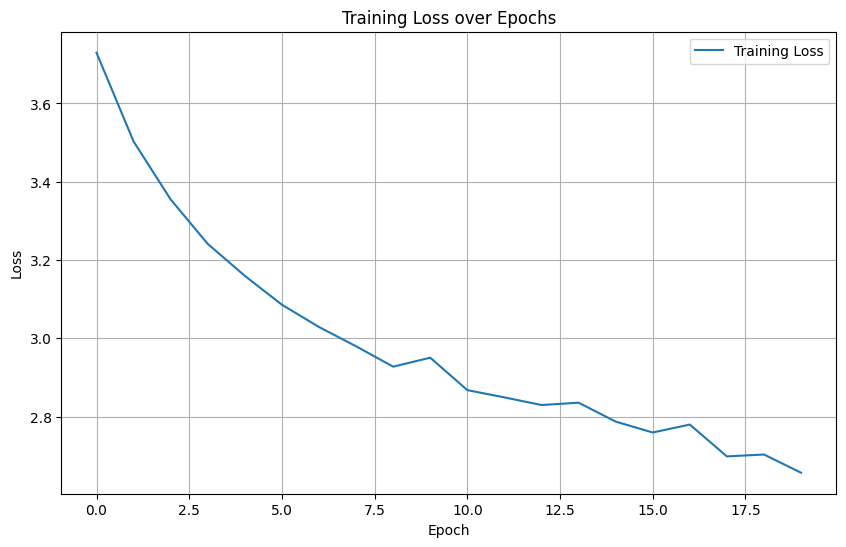

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

----

In [46]:
def compute_similarity_scores(model, data_loader):
    similarities = []
    labels = []
    
    for (acc_batch, gyro_batch), batch_labels in data_loader:
        # get embeddings
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) 
        # get embedding of accel and gyro
        
        # calculate cosine similarity between paired embeddings
        batch_similarities = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        similarities.extend(batch_similarities.numpy())
        labels.extend(batch_labels.numpy())
    
    return np.array(similarities), np.array(labels)

In [47]:
normal_similarities = []
for acc_batch, gyro_batch in tqdm(train_dataset, desc='Computing normal similarities'):
    # train set embedding -> similarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    normal_similarities.extend(sim.numpy())

test_similarities = []
test_pred_labels = []
for (acc_batch, gyro_batch), labels in tqdm(test_dataset, desc='Computing test similarities'):
    # test set embedding -> simiilarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    test_similarities.extend(sim.numpy())
    test_pred_labels.extend(labels.numpy())

Computing test similarities: 100%|████████████| 240/240 [00:44<00:00,  5.37it/s]


In [48]:
def calculate_similarities(model, test_dataset):
    normal_similarities = []
    fall_similarities = []
    
    for (acc_batch, gyro_batch), labels in test_dataset:
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
        
        sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        for sim_score, label in zip(sim.numpy(), labels.numpy()):
            if label == 0:  # normal
                normal_similarities.append(sim_score)
            else:  # fall
                fall_similarities.append(sim_score)
    
    return np.array(normal_similarities), np.array(fall_similarities)

normal_sims, fall_sims = calculate_similarities(model, test_dataset)

print("[ ADL data ]")
print(f"  Mean: {np.mean(normal_sims):.4f}")
print(f"  Std: {np.std(normal_sims):.4f}")
print(f"  Min: {np.min(normal_sims):.4f}")
print(f"  Max: {np.max(normal_sims):.4f}")
for i in range (20) :
    print ('ADL ind', i+1, ':', normal_sims[i])

print ()
print("[ FALL data ]")
print(f"  Mean: {np.mean(fall_sims):.4f}")
print(f"  Std: {np.std(fall_sims):.4f}")
print(f"  Min: {np.min(fall_sims):.4f}")
print(f"  Max: {np.max(fall_sims):.4f}")
for i in range (20) :
    print ('FALL ind', i+1, ':', fall_sims[i])

[ ADL data ]
  Mean: 0.9972
  Std: 0.0013
  Min: 0.9896
  Max: 0.9993
ADL ind 1 : 0.9983131
ADL ind 2 : 0.99835443
ADL ind 3 : 0.9988506
ADL ind 4 : 0.99904954
ADL ind 5 : 0.9980193
ADL ind 6 : 0.9976449
ADL ind 7 : 0.99818
ADL ind 8 : 0.99806994
ADL ind 9 : 0.9985939
ADL ind 10 : 0.9985931
ADL ind 11 : 0.9980884
ADL ind 12 : 0.9984453
ADL ind 13 : 0.9985794
ADL ind 14 : 0.998146
ADL ind 15 : 0.9980475
ADL ind 16 : 0.99809813
ADL ind 17 : 0.99811727
ADL ind 18 : 0.998196
ADL ind 19 : 0.9979156
ADL ind 20 : 0.9978392

[ FALL data ]
  Mean: 0.9966
  Std: 0.0019
  Min: 0.9827
  Max: 0.9993
FALL ind 1 : 0.99802834
FALL ind 2 : 0.99672866
FALL ind 3 : 0.9984311
FALL ind 4 : 0.9985167
FALL ind 5 : 0.9981018
FALL ind 6 : 0.99792933
FALL ind 7 : 0.99768865
FALL ind 8 : 0.9987271
FALL ind 9 : 0.99885845
FALL ind 10 : 0.9984117
FALL ind 11 : 0.99739295
FALL ind 12 : 0.99869937
FALL ind 13 : 0.99018914
FALL ind 14 : 0.98596317
FALL ind 15 : 0.9948805
FALL ind 16 : 0.9957801
FALL ind 17 : 0.994999

In [49]:
threshold = np.percentile(normal_similarities, 10)

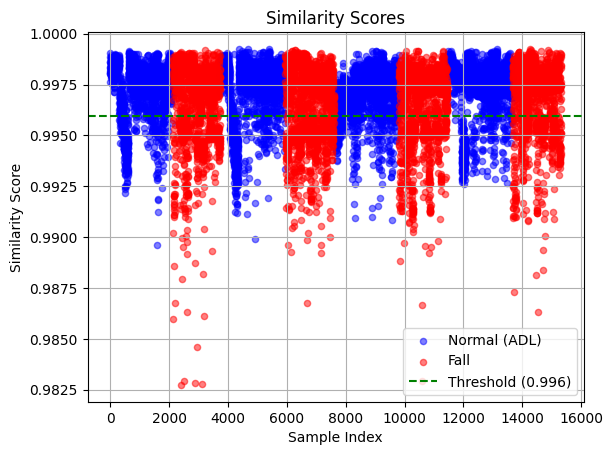

In [50]:
indices = range(len(test_similarities))
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 0], 
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 1],
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.3f})')
# plt.ylim(0.0078100, 0.0078150)
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores')
plt.legend()
plt.grid(True)

In [51]:
predictions = [1 if sim < threshold else 0 for sim in test_similarities] 
true_labels = test_pred_labels

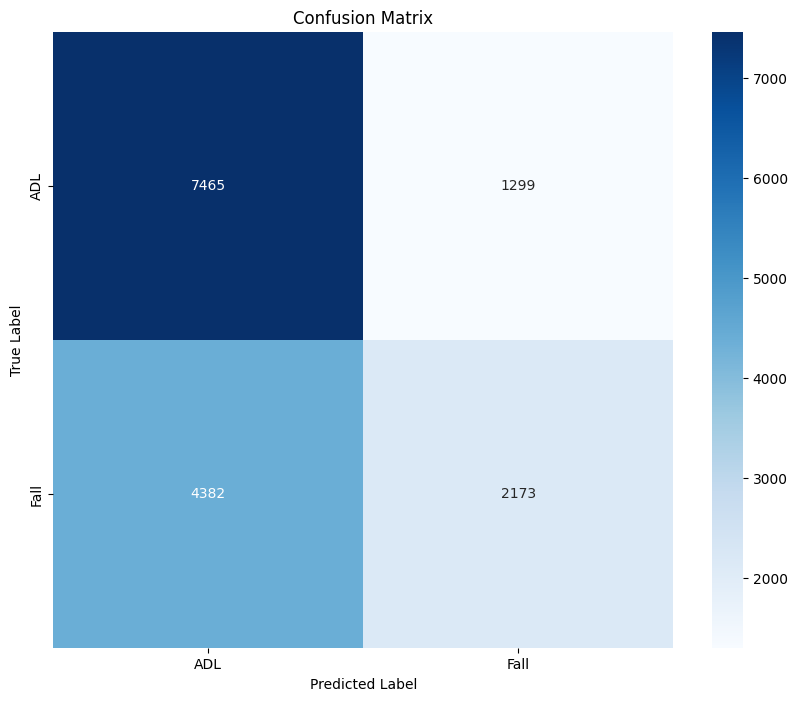

In [52]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
labels = ['ADL', 'Fall']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()

In [53]:
print ("classification report")
print(classification_report(true_labels, predictions, 
                          target_names=['ADL', 'Fall']))

classification report
              precision    recall  f1-score   support

         ADL       0.63      0.85      0.72      8764
        Fall       0.63      0.33      0.43      6555

    accuracy                           0.63     15319
   macro avg       0.63      0.59      0.58     15319
weighted avg       0.63      0.63      0.60     15319

